In [1]:
!pip install -r requirements.txt

In [4]:
import yaml
import numpy as np
import time
import tdmclient.notebook

In [5]:
#import scripts files
from scripts.vision import Vision
from scripts.global_nav import GlobalNav
from scripts.local_nav import LocalNav
from scripts.extended_kalman_filter import ExtendedKalmanFilter
from utils import utils

In [6]:
# Load the configuration file
with open('config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# General settings
dt = config['time_step']

# Thymio physical configuration
thymio_size = config['thymio']['size']  # mm
security_margin = config['thymio']['security_margin']  # mm
scale_speed = config['thymio']['speed_scale']  # thymio speed to mm/s
wheel_distance = config['thymio']['size']['wheel_distance']  # mm

# World configuration
world_width = config['world']['width']  # mm
world_height = config['world']['height']  # mm
obstacle_min_area = config['world']['obstacle_min_area']  # mm²
aruco_size = config['world']['aruco_size']  # mm

# Controller configuration
# Rotation parameters
angle_tolerance = np.deg2rad(config['controller']['angle_tolerance'])
scale_rotation_speed = config['controller']['scale_rotation_speed']
max_rotation_speed = config['controller']['max_rotation_speed']

# Translation parameters
distance_tolerance = config['controller']['distance_tolerance']  # mm
scale_translation_speed = config['controller']['scale_translation_speed']
min_translation_speed = config['controller']['min_translation_speed']
max_translation_speed = config['controller']['max_translation_speed']

# Obstacle avoidance parameters
kidnap_threshold = config['controller']['kidnap_threshold']
obstacles_max_iter = config['controller']['obstacles_max_iter']
obstacles_speed = config['controller']['obstacles_speed']
scale_sensor = config['controller']['scale_sensor']
weight_left = config['controller']['weight_left']
weight_right = config['controller']['weight_right']

# Camera configuration
webcam_device_id = config['webcam']['device_id']
webcam_resolution = config['webcam']['resolution']
webcam_padding = config['webcam']['padding']
webcam_matrix = np.array(config['webcam']['matrix'])
webcam_distortion = np.array(config['webcam']['distortion'])

# Extended Kalman Filter configuration
process_noise = np.diag(config['kalman']['process_noise'])
measurement_noise_covered = np.diag(config['kalman']['measurement_noise']['covered'])
measurement_noise_uncovered = np.diag(config['kalman']['measurement_noise']['uncovered'])

# Derived parameters
scale_factor = webcam_resolution[1] / world_width


In [15]:
await tdmclient.notebook.start()
print("Successfully connected to Thymio.")

Successfully connected to Thymio.


In [16]:
@tdmclient.notebook.sync_var
def motor_move(left,right):
    global motor_left_target, motor_right_target
    motor_left_target = left
    motor_right_target = right
    
@tdmclient.notebook.sync_var
def motor_stop():
    global motor_left_target,motor_right_target
    motor_left_target = 0
    motor_right_target = 0
    
@tdmclient.notebook.sync_var
def sensor_data():
    global prox_horizontal
    return prox_horizontal.copy()

print("Thymio functions defined correctly.")

Thymio functions defined correctly.


In [19]:
motor_move(50, 50)
time.sleep(1)
motor_stop()

In [20]:
vision = Vision(
    device_id=webcam_device_id,
    camera_matrix=webcam_matrix,
    dist_coeffs=webcam_distortion,
    resolution=webcam_resolution,
    padding=webcam_padding,
    scale_factor=scale_factor,
    world_width=world_width,
    world_height=world_height 
)
global_nav = GlobalNav(
    world_width=world_width,
    world_height=world_height,
    obstacle_min_area=obstacle_min_area,
    thymio_size=thymio_size,
    security_margin=security_margin,
    scale_factor=scale_factor,
    aruco_size=aruco_size
    
)
local_nav = LocalNav(
    angle_threshold=angle_tolerance,
    distance_threshold=distance_tolerance,
    scale_rotation_speed=scale_rotation_speed,
    max_rotation_speed=max_rotation_speed,
    scale_translation_speed=scale_translation_speed,
    min_translation_speed=min_translation_speed,
    max_translation_speed=max_translation_speed,
    obstacles_max_iter=obstacles_max_iter,
    obstacles_speed=obstacles_speed,
    scale_sensor=scale_sensor,
    weight_left=weight_left,
    weight_right=weight_right
)

ekf = ExtendedKalmanFilter(
    process_noise=process_noise,
    measurement_noise_covered=measurement_noise_covered,
    measurement_noise_uncovered=measurement_noise_uncovered
)

Vision Initialized
GlobalNav Initialized
LocalNav Initialized


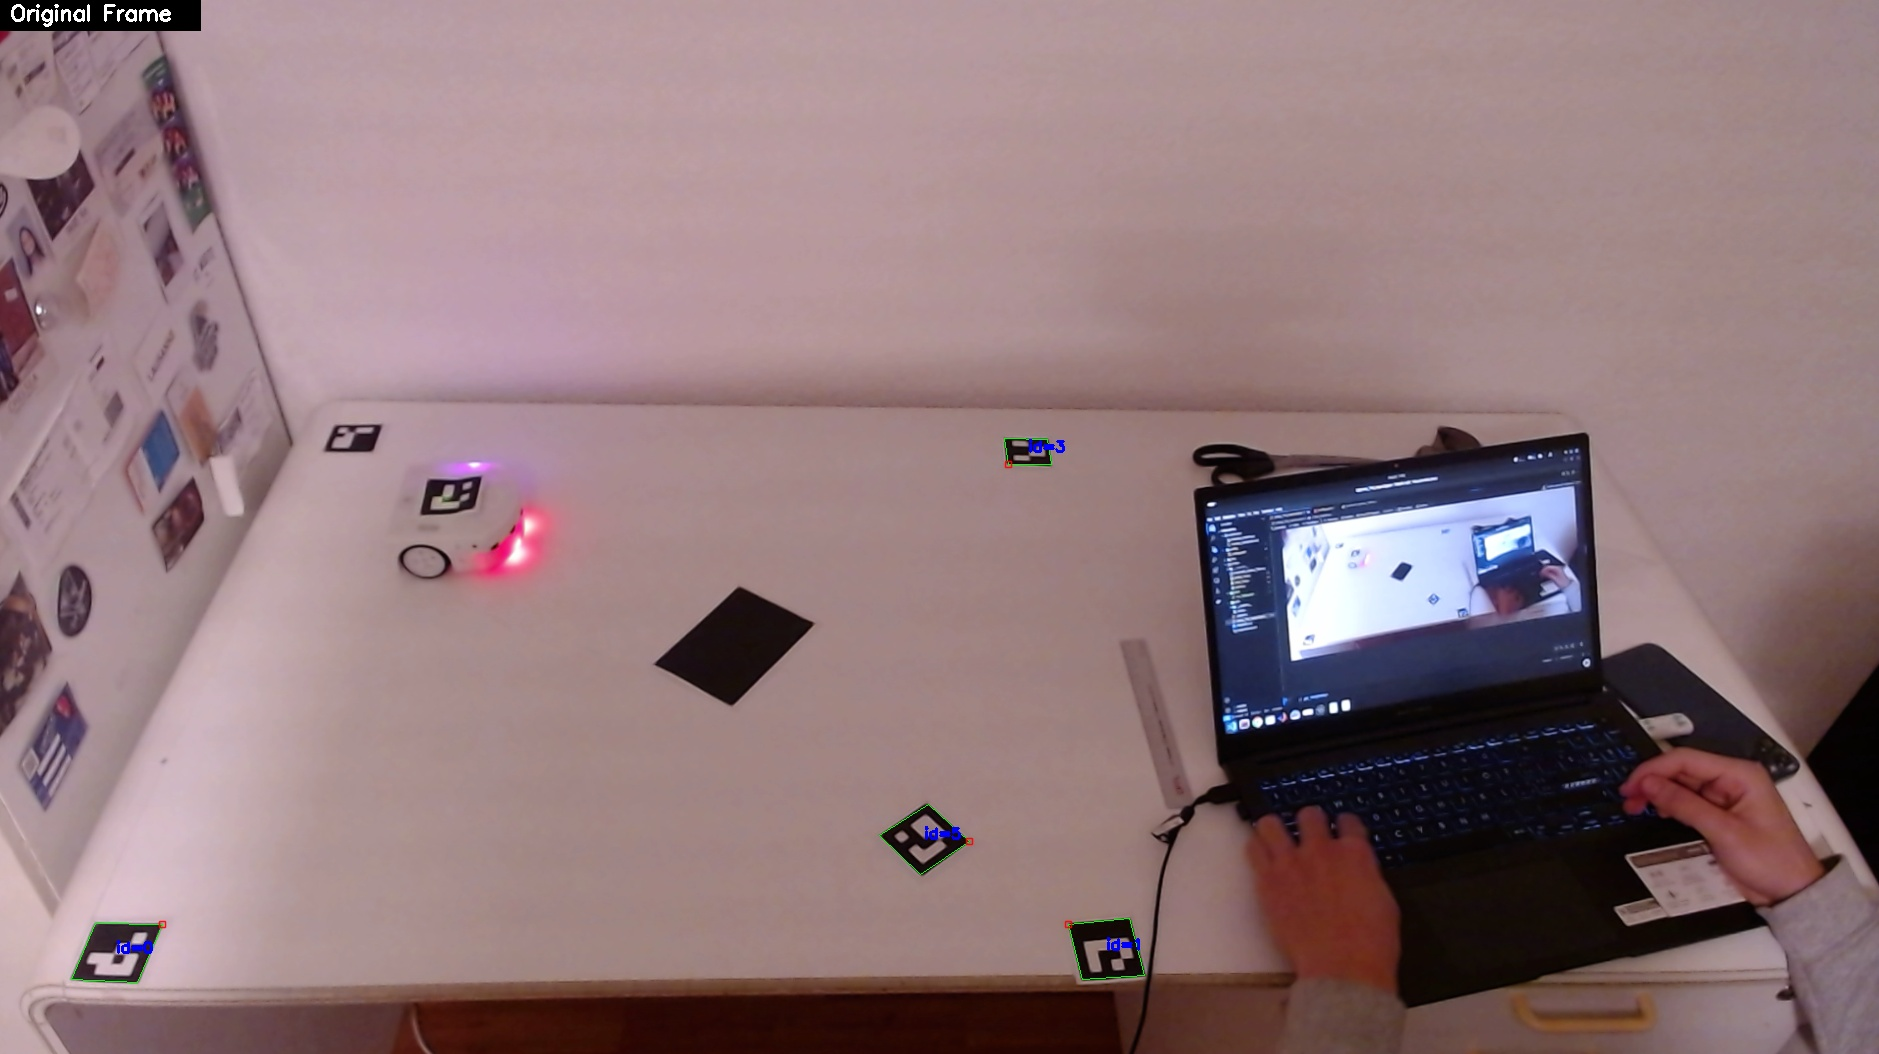

In [ ]:
# Global variables
got_trajectory = False
trajectory_frame = None
trajectory_pos = None
obstacles_pos = None
thymio_init_pos = None
thymio_init_orientation = None

try:
    # Try connecting to the webcam
    display(f"Trying to connect to device {webcam_device_id}...")
    if not vision.connect_webcam():
        display("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        display(f"Successfully connected to device {webcam_device_id}")
        
    print("Getting trajectory...")
    while not got_trajectory:
        original_frame, process_frame, thymio_init_pos, thymio_init_orientation, goal_pos, found_thymio, found_goal = vision.get_frame()
        
        utils.display_frames(original_frame, process_frame, None) 
        if found_thymio and found_goal:
            time.sleep(1)
            print("Thymio and goal found!")
            trajectory_frame, trajectory_pos, obstacles_pos, got_trajectory = global_nav.get_trajectory(process_frame, thymio_init_pos, goal_pos)
            print("Trajectory found!")
            ekf.initialize_state(np.array([thymio_init_pos[0], thymio_init_pos[1], thymio_init_orientation, 0.0, 0.0])) # x, y, theta, v, omega
            ekf.set_mode(covered=False) # Start in uncovered mode
            
        time.sleep(dt)
except KeyboardInterrupt:
    display("User interrupted the kernel. Closing the webcam...")

finally:
    # Release resources
    vision.cleanup_webcam()

In [13]:
if got_trajectory:
    obstacles_rounded = {k: np.round(v, 1) for k, v in obstacles_pos.items()}
    obstacles_formatted = '\n '.join([f"{k}: {v}" for k, v in obstacles_rounded.items()])
    print(f"Obstacles [mm]: \n {obstacles_formatted}")

    print(f"Trajectory points [mm]:\n {np.round(trajectory_pos, 1)}")
    print(f"Thymio position [mm]:\n {np.round(thymio_init_pos, 1)}")
    print(f"Thymio orientation [deg]:\n {np.round(np.rad2deg(thymio_init_orientation), 1)}")
    print(f"Goal position [mm]:\n {np.round(trajectory_pos[-1], 1)}")
else:
    print("Could not find a trajectory. Please try again.")

Obstacles [mm]: 
 obstacle1: [[322.6 140.2]
 [220.7 400.3]
 [411.3 473.5]
 [511.8 211.5]]
 obstacle4: [[ 32.2 160.7]
 [ 13.7 206.3]
 [ 20.8 268. ]
 [106.8 344.9]
 [201.3 334.9]
 [244.5 294.1]
 [250.  220.7]
 [189.3 135.3]
 [ 92.2 120.9]]
Trajectory points [mm]:
 [[140.6 134.2]
 [201.3 334.9]
 [220.7 400.3]
 [411.3 473.5]
 [566.5 508.8]]
Thymio position [mm]:
 [140.9 134.3]
Thymio orientation [deg]:
 -3.0999999046325684
Goal position [mm]:
 [566.5 508.8]


'User interrupted the kernel. Closing the webcam...'

Finished at time [s]: 23.5
Camera coverage [%]: 97.02127659574468


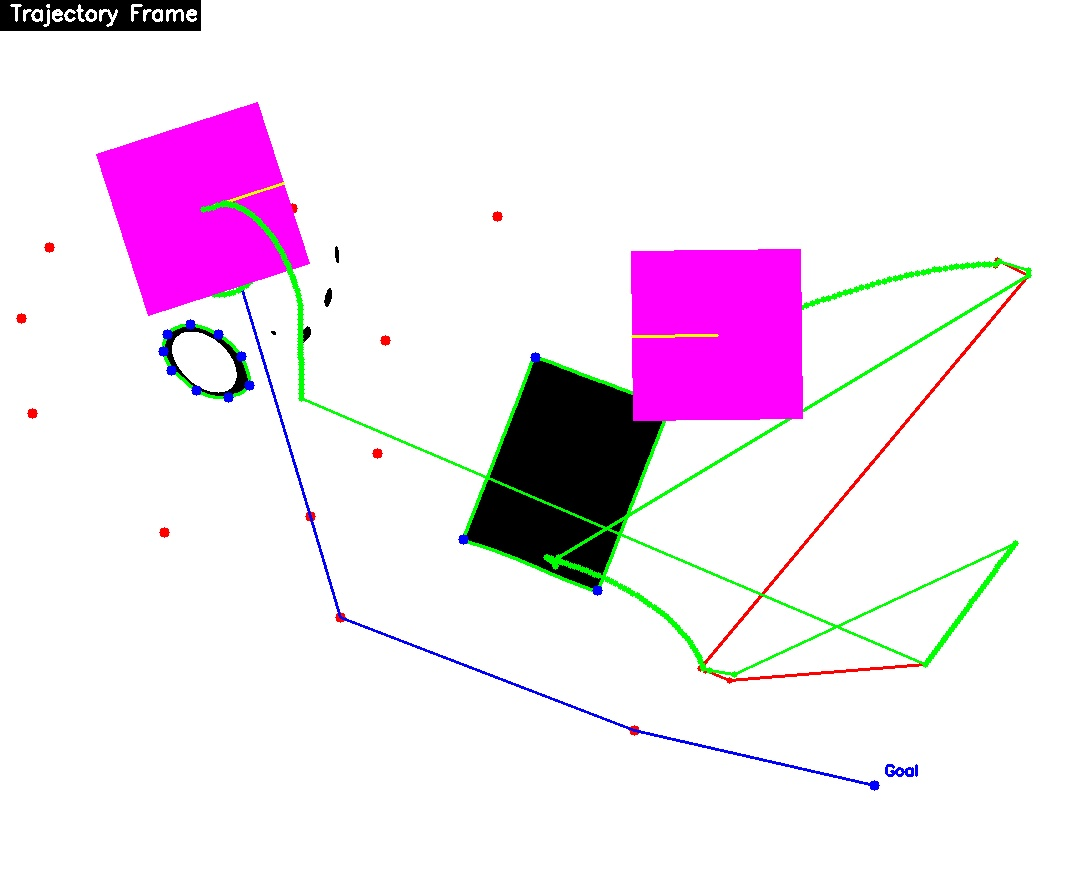

In [18]:
# Global variables
goal_reached = False
background_frame = None
thymio_old_pos = thymio_init_pos
position_measured_history = [] 
position_kalman_history = []   
i = 0
covered = 0
left_speed = 0 # left wheel speed
right_speed = 0 # right wheel speed

try:
    # Try connecting to the webcam
    display(f"Trying to connect to device {webcam_device_id}...")
    if not vision.connect_webcam():
        display("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        display(f"Successfully connected to device {webcam_device_id}")
    
    # If this is the first frame, create a copy of trajectory_frame as background
    if trajectory_frame is not None:
        background_frame = trajectory_frame.copy()
        
    while not goal_reached:
        i += 1
        original_frame, process_frame, thymio_pos, thymio_orientation, _, found_thymio, _ = vision.get_frame()
        
        # Predict step - using control inputs
        control_input = np.array([
            (left_speed + right_speed) / (2 * scale_speed),  # Linear velocity in mm/s
            (left_speed - right_speed) / (scale_speed*wheel_distance)  # Angular velocity in rad/s
        ])
        
        ekf.predict(control_input, dt)
        
        # Update measurement noise based on camera detection
        ekf.set_mode(covered=not found_thymio)
        
        if found_thymio:  # If thymio is detected
            position_measured_history.append(thymio_pos)
            measurement = np.array([
                thymio_pos[0], 
                thymio_pos[1], 
                thymio_orientation,
                control_input[0],  # Linear velocity
                control_input[1]  # Angular velocity
            ])
            
            # Update step with measurement
            ekf.update(measurement)
            
            # Get filtered state estimate
            filtered_state = ekf.get_state
            filtered_pos = np.array([filtered_state[0], filtered_state[1]])
            filtered_orientation = filtered_state[2]
            
            position_kalman_history.append(filtered_pos)
            
            # if utils.distance(thymio_old_pos, filtered_pos) > kidnap_threshold:
            #     display("KIDNAPPING")
            #     got_trajectory = False
            #     motor_stop()
            #     time.sleep(5)
            #     while not got_trajectory:
            #         original_frame, process_frame, thymio_pos, thymio_orientation, goal_pos, found_thymio, found_goal = vision.get_frame()
            #         utils.display_frames(original_frame, process_frame, None)
            #         time.sleep(1)
            #         if found_thymio and found_goal:
            #             up_frame, trajectory_pos, obstacles_pos, got_trajectory = global_nav.get_trajectory(process_frame, thymio_pos, goal_pos)
            #             background_frame = up_frame.copy()
            #             # Reinitalize local navigation
            #             local_nav.current_checkpoint = 0
            #             # Reinitialize EKF with new position
            #             new_state = np.array([thymio_pos[0], thymio_pos[1], thymio_orientation, 0.0, 0.0])
            #             ekf.initialize_state(new_state)
            #             display("New Trajectory Found!")
            #             time.sleep(1)
            #             utils.display_frames(None, None, up_frame)
            #             time.sleep(1)
                        
            thymio_old_pos = filtered_pos
        else:
            covered += 1
            # When robot is not visible, use only predicted state
            filtered_state = ekf.get_state
            filtered_pos = np.array([filtered_state[0], filtered_state[1]])
            filtered_orientation = filtered_state[2]
            position_kalman_history.append(filtered_pos)
            
        # Use filtered state for navigation
        command, goal_reached = local_nav.get_command(trajectory_pos, filtered_pos, filtered_orientation, sensor_data())
        
        if (command['action'] == 'follow_path') or (command['action'] == 'avoid_obstacles'):
                left_speed = command['left_speed']
                right_speed = command['right_speed']
                motor_move(left_speed, right_speed)
        else:
            motor_stop()

        # Update trajectory frame with robot
        if background_frame is not None:
            current_frame = background_frame.copy()
            # Draw measured trajectory in blue
            trajectory_frame = utils.draw_trajectory(current_frame, position_measured_history, scale_factor, color=(255, 0, 0))
            # Draw filtered trajectory in green
            trajectory_frame = utils.draw_trajectory(trajectory_frame, position_kalman_history, scale_factor, color=(0, 255, 0))
            # Draw robot using filtered position
            trajectory_frame = utils.draw_robot(trajectory_frame, filtered_pos, filtered_orientation, thymio_size, scale_factor)

        utils.display_frames(original_frame, None, trajectory_frame) 
        time.sleep(dt)
        
except KeyboardInterrupt:
    local_nav.current_checkpoint = 0
    motor_stop()
    display("User interrupted the kernel. Closing the webcam...")
finally:
    # Release resources
    vision.cleanup_webcam()
    motor_stop()
    local_nav.current_checkpoint = 0
    print("Finished at time [s]:", i * dt)
    print("Camera coverage [%]:", covered/i * 100)
    utils.display_frames(None, None, trajectory_frame)

Simulation interrupted
Finished at time [s]: 11.64


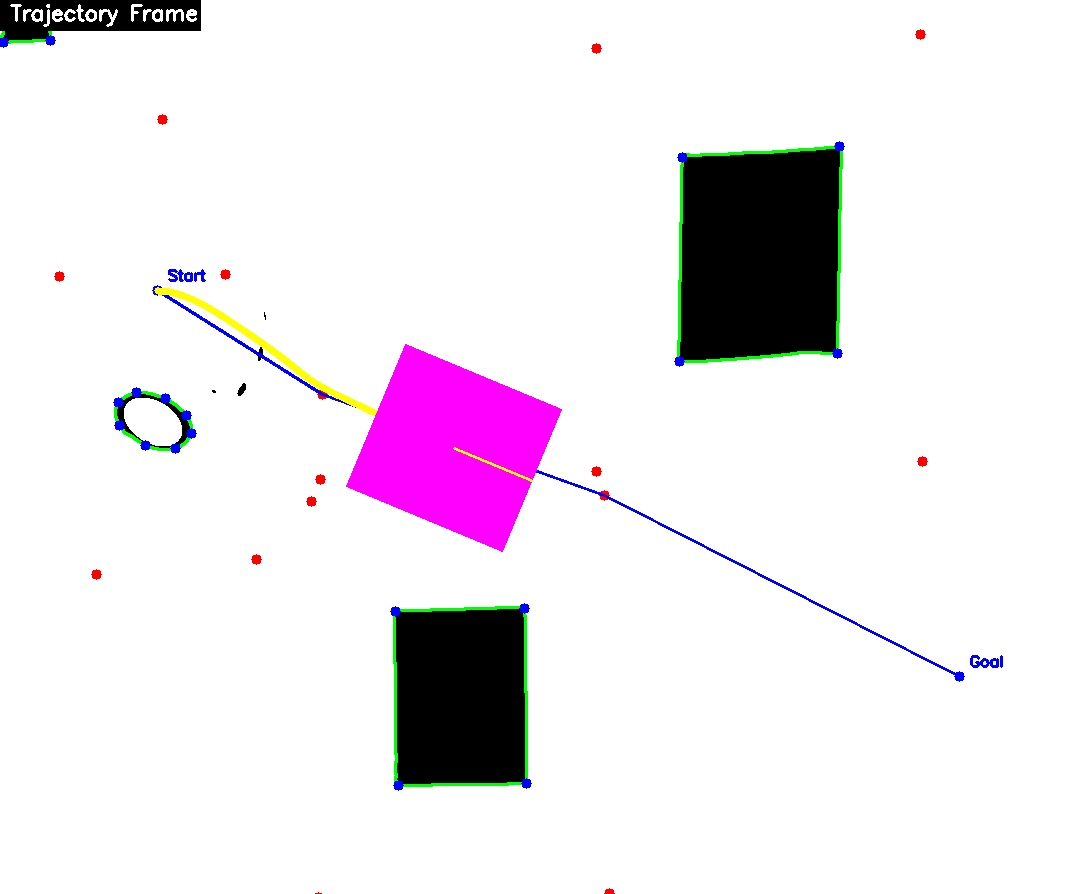

In [12]:
up_frame = trajectory_frame.copy()

def sensor_data():
    return [0, 0, 0, 0, 0, 0, 0, 0]

def update_position(thymio_pos, thymio_orientation, left_speed, right_speed, thymio_width, dt):
    # Convert speeds to velocities
    linear_velocity = (left_speed + right_speed) / 2  
    angular_velocity = (left_speed - right_speed) / thymio_width
    
    # Update orientation and position
    thymio_orientation += angular_velocity * dt
    delta_x = linear_velocity * np.cos(thymio_orientation) * dt
    delta_y = linear_velocity * np.sin(thymio_orientation) * dt
    
    new_pos = (thymio_pos[0] + delta_x, thymio_pos[1] + delta_y)
    
    return new_pos, thymio_orientation

goal_reached = False
thymio_pos = thymio_init_pos
thymio_orientation = 0
position_measured_history = []
position_estimated_history = []  # Add history for EKF estimates
i = 0
left_speed = 0 
right_speed = 0

try:
    # Try connecting to the webcam
    display(f"Trying to connect to device {webcam_device_id}...")
    if not vision.connect_webcam():
        display("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        display(f"Successfully connected to device {webcam_device_id}")
        if up_frame is not None:
            background_frame = up_frame.copy()
        
        while not goal_reached:
            i += 1
            
            # Get control input for EKF
            linear_velocity = (left_speed + right_speed) / 2
            angular_velocity = (left_speed - right_speed) / thymio_size['width']
            control_input = np.array([linear_velocity, angular_velocity])
            
            # EKF Prediction step
            ekf.predict(control_input, dt)
            
            # Get vision measurement (simulated here - replace with actual vision data)
            vision_measurement = np.array([thymio_pos[0], thymio_pos[1], thymio_orientation, linear_velocity, angular_velocity])
            
            # EKF Update step
            ekf.update(vision_measurement)
            
            # Get estimated state from EKF
            estimated_state = ekf.get_state
            estimated_pos = np.array([estimated_state[0], estimated_state[1]])
            estimated_orientation = estimated_state[2]
            
            # Store histories
            position_measured_history.append(thymio_pos)
            position_estimated_history.append(estimated_pos)
            
            # Use EKF estimated position for navigation
            command, goal_reached = local_nav.get_command(
                trajectory_pos, 
                estimated_pos,  # Use EKF estimate instead of raw position
                estimated_orientation,  # Use EKF estimate
                sensor_data()
            )
            
            if command['action'] in ['follow_path', 'avoid_obstacle']:
                left_speed = command['left_speed'] 
                right_speed = command['right_speed']
            else:
                left_speed = 0
                right_speed = 0
            
            # Update position through simulation
            new_pos, thymio_orientation = update_position(
                thymio_pos, 
                thymio_orientation,
                left_speed, 
                right_speed,
                thymio_size['width'],
                dt
            )
            thymio_pos = np.array(new_pos)
            
            # Update trajectory frame with robot
            if background_frame is not None:
                current_frame = background_frame.copy()
                # Draw measured trajectory in one color
                up_frame = utils.draw_trajectory(current_frame, position_measured_history, scale_factor, color=(0, 255, 255), )
                # Draw estimated trajectory in different color
                up_frame = utils.draw_trajectory(up_frame, position_estimated_history, scale_factor, color=(255, 255, 0))
                # Draw robot using estimated position
                up_frame = utils.draw_robot(up_frame, estimated_pos, estimated_orientation, thymio_size, scale_factor)
                # Draw uncertainty ellipse
                covariance = ekf.get_covariance
                up_frame = utils.draw_uncertainty_ellipse(up_frame, estimated_pos, covariance[:2, :2], scale_factor)
                
                utils.display_frames(None, None, up_frame)
            
            time.sleep(dt)
            
except KeyboardInterrupt:
    local_nav.current_checkpoint = 0
    print("Simulation interrupted")
finally:
    vision.cleanup_webcam()
    local_nav.current_checkpoint = 0
    print("Finished at time [s]:", i * dt)
    utils.display_frames(None, None, up_frame)


In [20]:
await tdmclient.notebook.stop()